In [15]:
import os
from glob import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import matplotlib.colors as mcolors
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Reshape

In [3]:
batch_size = 6
lr = 1e-3
epochs = 100
width = 512
height = 512

In [4]:
dataset_path = os.path.join("/kaggle/input/uavid-v1")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [5]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "uavid_train","seq1", "Images", "*")))
    train_y = sorted(glob(os.path.join(path, "uavid_train","seq1", "Labels", "*")))

    valid_x = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Images", "*")))
    valid_y = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Labels", "*")))

    return (train_x, train_y), (valid_x, valid_y)

In [6]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

train_x, additional_valid_x, train_y, additional_valid_y = train_test_split(
    train_x, train_y, test_size=100, random_state=42
)

valid_x = np.concatenate([valid_x, additional_valid_x], axis=0)
valid_y = np.concatenate([valid_y, additional_valid_y], axis=0)


print(f"New Train: {len(train_x)} - {len(train_y)}")
print(f"New Valid: {len(valid_x)} - {len(valid_y)}")

New Train: 500 - 500
New Valid: 170 - 170


In [7]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [8]:
color_map = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building
    (128, 64, 128): 2,    # Road
    (0, 128, 0): 3,       # Tree
    (128, 128, 0): 4,     # Low vegetation
    (64, 0, 128): 5,      # Moving car
    (192, 0, 192): 6,     # Static car
    (64, 64, 0): 7        # Human
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)  
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) 
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

    class_indices = np.zeros((height, width), dtype=np.uint8)

    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx

    return class_indices.astype(np.uint8) 

In [9]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x) 
        y = read_mask(y) 
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.uint8]) 
    x.set_shape([height, width, 3]) 
    y.set_shape([height, width])   
    return x, y

In [10]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [17]:
# Channel Attention Function
def channel_attention(x, channel, reduction=16):
    # Global Average Pooling
    avg_pool = layers.GlobalAveragePooling2D()(x)
    fc1 = layers.Dense(channel // reduction, activation='relu')(avg_pool)
    fc2 = layers.Dense(channel)(fc1)
    attention = Activation('sigmoid')(fc2)
    attention = layers.Reshape((1, 1, channel))(attention)  # Use Keras Reshape
    refined = x * attention
    return refined

# Spatial Attention Function
def spatial_attention(x, channel, reduction=16, dilation_conv_num=2):
    spatial = layers.Conv2D(channel // reduction, kernel_size=1, activation='relu')(x)
    for dilation in range(1, dilation_conv_num + 1):
        spatial = layers.Conv2D(channel // reduction, kernel_size=3, padding='same', dilation_rate=dilation, activation='relu')(spatial)
    spatial = layers.Conv2D(1, kernel_size=1)(spatial)
    attention = Activation('sigmoid')(spatial)
    refined = x * attention
    return refined

# BAM Function: Combine Channel and Spatial Attention
def BAM(x, reduction=16, dilation_conv_num=2):
    channel = x.shape[-1]
    # Apply Channel Attention
    channel_refined = channel_attention(x, channel, reduction)
    
    # Apply Spatial Attention on the result of Channel Attention
    spatial_refined = spatial_attention(channel_refined, channel, reduction, dilation_conv_num)
    
    # Combine the attention features: input * spatial_attention + input * channel_attention
    refined_feature = x * spatial_refined + x * channel_refined
    return refined_feature

In [18]:
def SegUNet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):

    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (kernel, kernel), padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    conv2 = Conv2D(64, (kernel, kernel), padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool1 = MaxPooling2D(pool_size)(conv2)

    conv3 = Conv2D(128, (kernel, kernel), padding="same")(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    conv4 = Conv2D(128, (kernel, kernel), padding="same")(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    pool2 = MaxPooling2D(pool_size)(conv4)

    conv5 = Conv2D(256, (kernel, kernel), padding="same")(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    conv6 = Conv2D(256, (kernel, kernel), padding="same")(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)
    conv6 = BAM(conv6)  # Applying BAM here
    conv7 = Conv2D(256, (kernel, kernel), padding="same")(conv6)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)
    pool3 = MaxPooling2D(pool_size)(conv7)

    conv8 = Conv2D(512, (kernel, kernel), padding="same")(pool3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)
    conv9 = Conv2D(512, (kernel, kernel), padding="same")(conv8)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = BAM(conv9)  # Applying BAM here
    conv10 = Conv2D(512, (kernel, kernel), padding="same")(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    pool4 = MaxPooling2D(pool_size)(conv10)

    conv11 = Conv2D(512, (kernel, kernel), padding="same")(pool4)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    conv12 = Conv2D(512, (kernel, kernel), padding="same")(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)
    conv12 = BAM(conv12)  # Applying BAM here
    conv13 = Conv2D(512, (kernel, kernel), padding="same")(conv12)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation("relu")(conv13)
    pool5 = MaxPooling2D(pool_size)(conv13)

    # Decoder
    conv14 = Conv2D(512, (kernel, kernel), padding="same")(pool5)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation("relu")(conv14)
    conv15 = Conv2D(512, (kernel, kernel), padding="same")(conv14)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation("relu")(conv15)
    conv15 = BAM(conv15)  # Applying BAM here
    conv16 = Conv2D(512, (kernel, kernel), padding="same")(conv15)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation("relu")(conv16)
    up1 = UpSampling2D(pool_size)(conv16)
    concat1 = Concatenate()([up1, conv13])

    conv17 = Conv2D(512, (kernel, kernel), padding="same")(concat1)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation("relu")(conv17)
    conv18 = Conv2D(512, (kernel, kernel), padding="same")(conv17)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation("relu")(conv18)
    conv18 = BAM(conv18)  # Applying BAM here
    conv19 = Conv2D(512, (kernel, kernel), padding="same")(conv18)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation("relu")(conv19)
    up2 = UpSampling2D(pool_size)(conv19)
    concat2 = Concatenate()([up2, conv10])

    conv20 = Conv2D(512, (kernel, kernel), padding="same")(concat2)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation("relu")(conv20)
    conv21 = Conv2D(512, (kernel, kernel), padding="same")(conv20)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation("relu")(conv21)
    conv21 = BAM(conv21)  # Applying BAM here
    conv22 = Conv2D(256, (kernel, kernel), padding="same")(conv21)
    conv22 = BatchNormalization()(conv22)
    conv22 = Activation("relu")(conv22)
    up3 = UpSampling2D(pool_size)(conv22)
    concat3 = Concatenate()([up3, conv7])

    conv23 = Conv2D(256, (kernel, kernel), padding="same")(concat3)
    conv23 = BatchNormalization()(conv23)
    conv23 = Activation("relu")(conv23)
    conv24 = Conv2D(256, (kernel, kernel), padding="same")(conv23)
    conv24 = BatchNormalization()(conv24)
    conv24 = Activation("relu")(conv24)
    conv24 = BAM(conv24)  # Applying BAM here
    conv25 = Conv2D(128, (kernel, kernel), padding="same")(conv24)
    conv25 = BatchNormalization()(conv25)
    conv25 = Activation("relu")(conv25)
    up4 = UpSampling2D(pool_size)(conv25)
    concat4 = Concatenate()([up4, conv4])

    conv26 = Conv2D(128, (kernel, kernel), padding="same")(concat4)
    conv26 = BatchNormalization()(conv26)
    conv26 = Activation("relu")(conv26)
    conv27 = Conv2D(64, (kernel, kernel), padding="same")(conv26)
    conv27 = BatchNormalization()(conv27)
    conv27 = Activation("relu")(conv27)
    up5 = UpSampling2D(pool_size)(conv27)
    concat5 = Concatenate()([up5, conv2])

    conv28 = Conv2D(64, (kernel, kernel), padding="same")(concat5)
    conv28 = BatchNormalization()(conv28)
    conv28 = Activation("relu")(conv28)

    conv29 = Conv2D(n_labels, (1, 1), padding="valid")(conv28)
    conv29 = BatchNormalization()(conv29)
    outputs = Activation(output_mode)(conv29)
    
    model = Model(inputs, outputs)
    
    return model


In [19]:
input_shape = (512, 512, 3)
model = SegUNet(input_shape, 8)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 512, 512,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation_6[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 256, 256,  │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_8[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_10[0][0] 

 Total params: 42,413,487 (161.79 MB)

 Trainable params: 42,394,527 (161.72 MB)

 Non-trainable params: 18,960 (74.06 KB)

In [21]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["sparse_categorical_accuracy"])

In [22]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [23]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100


I0000 00:00:1730893551.276685      92 service.cc:145] XLA service 0x7cddf80055a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730893551.276753      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1730893555.245889      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1730893613.854146      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_bitcast_reduce_fusion_6', 52 bytes spill stores, 52 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_bitcast_reduce_fusion', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1730893613.905067      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - loss: 1.6566 - sparse_categorical_accuracy: 0.4493

W0000 00:00:1730893698.168189      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6546 - sparse_categorical_accuracy: 0.4502   

W0000 00:00:1730893732.973701      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1730893759.401830      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 3.26657, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - loss: 1.6527 - sparse_categorical_accuracy: 0.4510 - val_loss: 3.2666 - val_sparse_categorical_accuracy: 0.1147 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - loss: 1.3330 - sparse_categorical_accuracy: 0.5787
Epoch 2: val_loss improved from 3.26657 to 3.07219, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 1.3326 - sparse_categorical_accuracy: 0.5788 - val_loss: 3.0722 - val_sparse_categorical_accuracy: 0.1238 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - loss: 1.2330 - sparse_categorical_accuracy: 0.6048
Epoch 3: val_loss improved from 3.07219 to 3.02971, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 1.2327 - sparse_categorical_accuracy: 0.6049 - v

In [26]:
datasetpath = "/kaggle/input/uavid-v1/uavid_test"
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [28]:
model = tf.keras.models.load_model(model_file)

Index(['epoch', 'learning_rate', 'loss', 'sparse_categorical_accuracy',
       'val_loss', 'val_sparse_categorical_accuracy'],
      dtype='object')


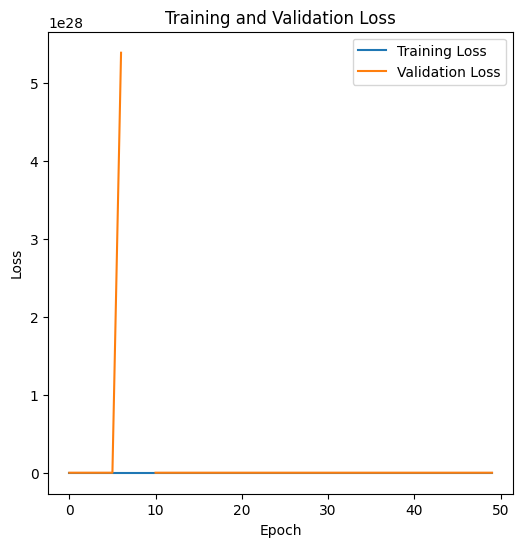

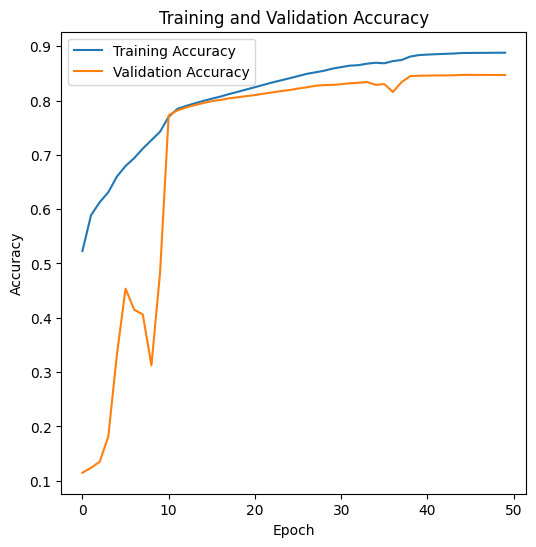

In [29]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

In [30]:
test_x = sorted(glob(os.path.join(dataset_path, "uavid_test", "*", "Images", "*")))
print(f"Test: {len(test_x)}")

Test: 150


In [31]:
time_taken = []
for x in tqdm(test_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


  1%|          | 1/150 [00:07<17:31,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|▏         | 2/150 [00:07<07:48,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 3/150 [00:07<04:41,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 4/150 [00:08<03:13,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 5/150 [00:08<02:24,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▍         | 6/150 [00:09<01:55,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  5%|▍         | 7/150 [00:09<01:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 8/150 [00:10<01:24,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 9/150 [00:10<01:15,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 10/150 [00:10<01:08,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 11/150 [00:11<01:03,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 12/150 [00:11<01:01,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▊         | 13/150 [00:12<00:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▉         | 14/150 [00:12<00:59,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 15/150 [00:12<00:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█         | 16/150 [00:13<00:57,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|█▏        | 17/150 [00:13<00:58,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 12%|█▏        | 18/150 [00:14<00:57,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 19/150 [00:14<00:56,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 20/150 [00:15<00:56,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 21/150 [00:15<00:54,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 22/150 [00:15<00:53,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 23/150 [00:16<00:51,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 24/150 [00:16<00:50,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 25/150 [00:17<00:48,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 26/150 [00:17<00:47,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 27/150 [00:17<00:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 28/150 [00:18<00:45,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 29/150 [00:18<00:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 30/150 [00:18<00:48,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██        | 31/150 [00:19<00:47,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|██▏       | 32/150 [00:19<00:48,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 33/150 [00:20<00:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 34/150 [00:20<00:45,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 35/150 [00:20<00:45,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 36/150 [00:21<00:44,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|██▍       | 37/150 [00:21<00:43,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 38/150 [00:22<00:42,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|██▌       | 39/150 [00:22<00:42,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██▋       | 40/150 [00:22<00:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 41/150 [00:23<00:43,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 28%|██▊       | 42/150 [00:23<00:42,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▊       | 43/150 [00:24<00:43,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 44/150 [00:24<00:42,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|███       | 45/150 [00:24<00:44,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|███       | 46/150 [00:25<00:43,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 47/150 [00:25<00:42,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 48/150 [00:26<00:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 49/150 [00:26<00:41,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 50/150 [00:26<00:40,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▍      | 51/150 [00:27<00:40,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 52/150 [00:27<00:39,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▌      | 53/150 [00:28<00:39,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███▌      | 54/150 [00:28<00:39,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 55/150 [00:28<00:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 37%|███▋      | 56/150 [00:29<00:39,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 57/150 [00:29<00:38,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 58/150 [00:30<00:37,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 59/150 [00:30<00:36,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|████      | 60/150 [00:31<00:36,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 61/150 [00:31<00:36,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████▏     | 62/150 [00:31<00:36,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 63/150 [00:32<00:36,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 64/150 [00:32<00:35,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|████▎     | 65/150 [00:33<00:34,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 66/150 [00:33<00:33,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▍     | 67/150 [00:33<00:33,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 68/150 [00:34<00:33,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████▌     | 69/150 [00:34<00:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 70/150 [00:35<00:32,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|████▋     | 71/150 [00:35<00:31,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|████▊     | 72/150 [00:35<00:31,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▊     | 73/150 [00:36<00:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 74/150 [00:36<00:31,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|█████     | 75/150 [00:37<00:31,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 76/150 [00:37<00:30,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████▏    | 77/150 [00:38<00:31,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 78/150 [00:38<00:30,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 79/150 [00:38<00:29,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 80/150 [00:39<00:29,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 81/150 [00:39<00:29,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▍    | 82/150 [00:40<00:28,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████▌    | 83/150 [00:40<00:28,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|█████▌    | 84/150 [00:40<00:28,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 85/150 [00:41<00:27,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 86/150 [00:41<00:27,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|█████▊    | 87/150 [00:42<00:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▊    | 88/150 [00:42<00:27,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 89/150 [00:43<00:26,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 90/150 [00:43<00:25,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 91/150 [00:44<00:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████▏   | 92/150 [00:44<00:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 93/150 [00:45<00:27,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 63%|██████▎   | 94/150 [00:45<00:26,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|██████▎   | 95/150 [00:45<00:25,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▍   | 96/150 [00:46<00:24,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▍   | 97/150 [00:46<00:23,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████▌   | 98/150 [00:47<00:22,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 99/150 [00:47<00:21,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 100/150 [00:48<00:21,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|██████▋   | 101/150 [00:48<00:21,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████▊   | 102/150 [00:48<00:21,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▊   | 103/150 [00:49<00:20,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████▉   | 104/150 [00:49<00:20,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████   | 105/150 [00:50<00:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 106/150 [00:50<00:19,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|███████▏  | 107/150 [00:51<00:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 108/150 [00:51<00:18,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 109/150 [00:52<00:17,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████▎  | 110/150 [00:52<00:16,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████▍  | 111/150 [00:52<00:15,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|███████▍  | 112/150 [00:53<00:15,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 113/150 [00:53<00:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 114/150 [00:53<00:13,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 115/150 [00:54<00:13,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████▋  | 116/150 [00:54<00:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████▊  | 117/150 [00:55<00:12,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▊  | 118/150 [00:55<00:12,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 119/150 [00:55<00:11,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|████████  | 120/150 [00:56<00:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 121/150 [00:56<00:10,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|████████▏ | 122/150 [00:56<00:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 123/150 [00:57<00:10,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 124/150 [00:57<00:10,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████▎ | 125/150 [00:58<00:09,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 126/150 [00:58<00:09,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▍ | 127/150 [00:58<00:08,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|████████▌ | 128/150 [00:59<00:08,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|████████▌ | 129/150 [00:59<00:08,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████▋ | 130/150 [01:00<00:07,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████▋ | 131/150 [01:00<00:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 132/150 [01:00<00:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|████████▊ | 133/150 [01:01<00:06,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|████████▉ | 134/150 [01:01<00:06,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|█████████ | 135/150 [01:01<00:05,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|█████████ | 136/150 [01:02<00:05,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|█████████▏| 137/150 [01:02<00:05,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 138/150 [01:03<00:04,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 139/150 [01:03<00:04,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|█████████▎| 140/150 [01:03<00:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 141/150 [01:04<00:03,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▍| 142/150 [01:04<00:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 143/150 [01:05<00:02,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████▌| 144/150 [01:05<00:02,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████▋| 145/150 [01:05<00:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████▋| 146/150 [01:06<00:01,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 147/150 [01:06<00:01,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▊| 148/150 [01:07<00:00,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|█████████▉| 149/150 [01:07<00:00,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████| 150/150 [01:07<00:00,  2.21it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


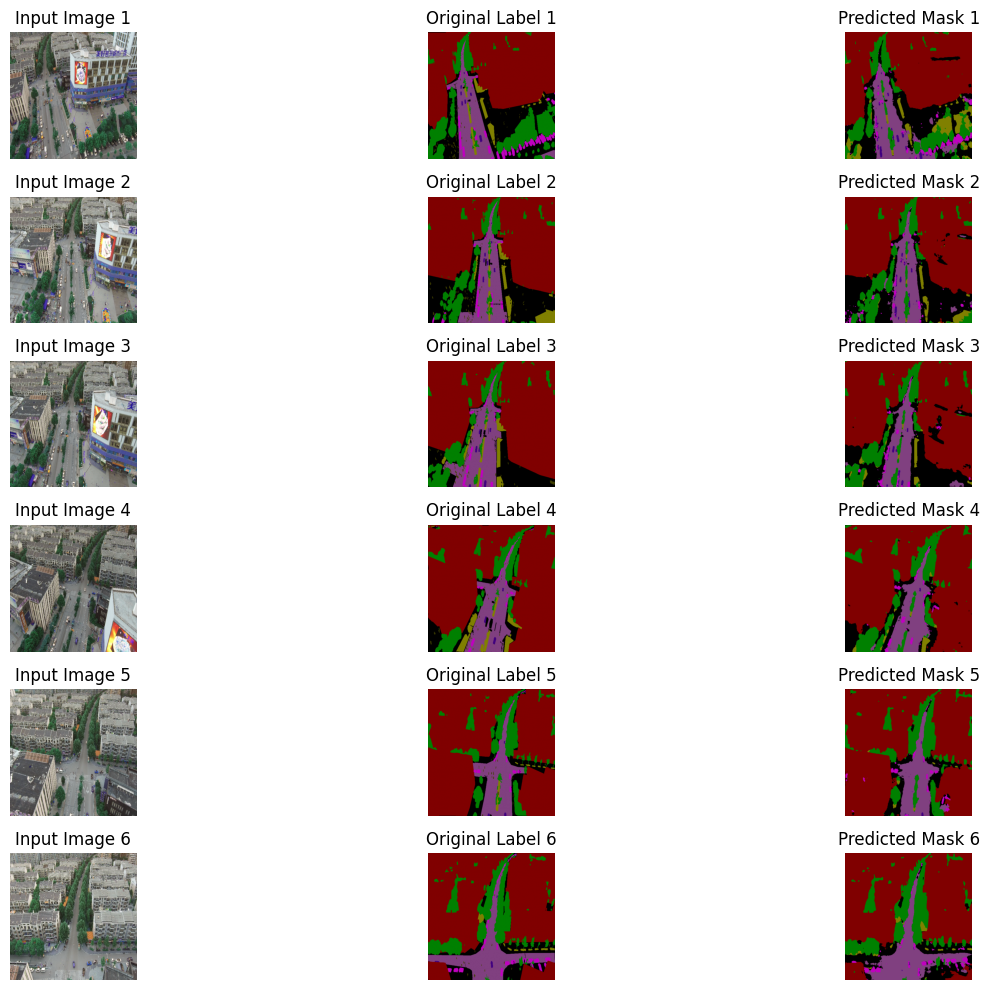

In [32]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(valid_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = valid_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [33]:
!zip -r BAMSEGU.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'BAMSEGU.zip')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_loss.png (deflated 17%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_accuracy.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/Log-Unet.csv (deflated 58%)
  adding: kaggle/working/files/modified_uavid_dataset/UnetModel.keras (deflated 7%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq25_000100.png (deflated 12%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq42_000400.png (deflated 15%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/seq42_000500.png (deflated 9%)
  adding: kaggle/working/Prediction

/kaggle/working/BAMSEGU.zip